In [1]:
import numpy as np
import pandas as pd
from earthscopestraintools.gtsm_metadata import GtsmMetadata
from earthscopestraintools.timeseries import ts_from_mseed
from earthscopestraintools.event import Earthquake
from earthscopestraintools.event_processing import magnitude_plot, plot_coseismic_offset, calc_hypocentral_dist
from datetime import datetime, timedelta

import logging
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter("%(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.ERROR)


In [2]:
network = 'PB'
station = 'B944'
meta = GtsmMetadata(network,station)
meta.get_event_terms()

In [20]:
def plot_event(station, meta, event_id):
    period = 20
    eq = Earthquake(event_id=event_id)
    hypocentral_distance = calc_hypocentral_dist(eq.lat,
                                                 eq.long,
                                                 eq.depth,
                                                 meta.latitude,
                                                 meta.longitude)
    start = (eq.time - timedelta(seconds=15)).strftime("%Y-%m-%dT%H:%M:%S")
    end = (eq.time + timedelta(seconds=120)).strftime("%Y-%m-%dT%H:%M:%S")
    ts1 = ts_from_mseed(network=network, station=station, location='T0', channel='BS*', start=start, end=end)
    #ts1.plot()
    ts2 = ts1.linearize(reference_strains=meta.reference_strains, gap=meta.gap)
    #ts2.plot()
    ts3 = ts2.interpolate(method='linear', limit_seconds=3600)
    #ts3.plot()
    ts4 = ts3.butterworth_filter(filter_type='high', filter_order=2, filter_cutoff_s=1000)
    #ts4.plot()
    ts5 = ts4.dynamic_strain()
    #ts5.plot()
    ts6 = ts5.calculate_magnitude(hypocentral_distance, meta.site_term, meta.longitude_term)
    title = f"{network}.{station} at {hypocentral_distance} km from {eq.name} {eq.time.isoformat(timespec='seconds')}"
    magnitude_plot(dynamic_strain_df=ts5.data, 
               magnitude_df=ts6.data, 
               eq_time=eq.time, 
               eq_mag=eq.mag, 
               title=title)

uu60497322 36 km S of Silver Gate, Montana 2022-05-11T13:32:02+00:00
uu60203137 12 km E of Hebgen Lake Estates, Montana 2017-06-16T00:48:46+00:00
us10004t1f 23 km SE of Kelly, Wyoming 2016-02-26T23:00:39+00:00
uu60061837 22 km S of Mammoth, Wyoming 2014-03-30T12:34:39+00:00
usp000hngw 20 km E of Kelly, Wyoming 2010-10-24T17:43:59+00:00
usp000hjav 22 km E of Kelly, Wyoming 2010-08-17T02:49:55+00:00
usp000hhkt 19 km E of Kelly, Wyoming 2010-08-05T14:59:29+00:00
usp000hhj8 19 km E of Kelly, Wyoming 2010-08-05T00:04:17+00:00


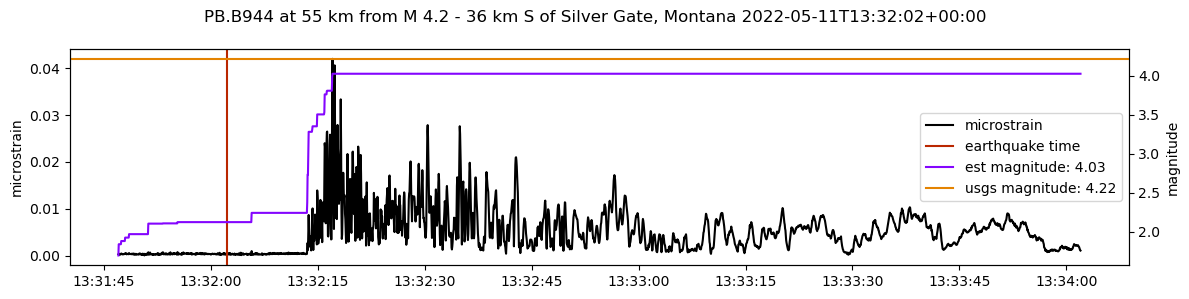

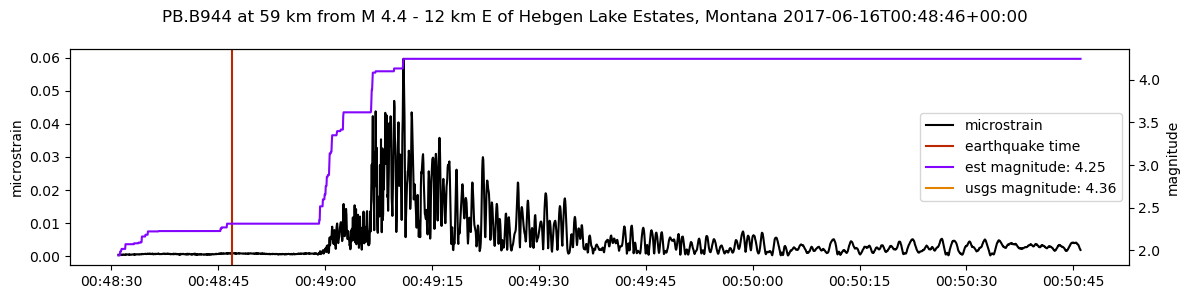

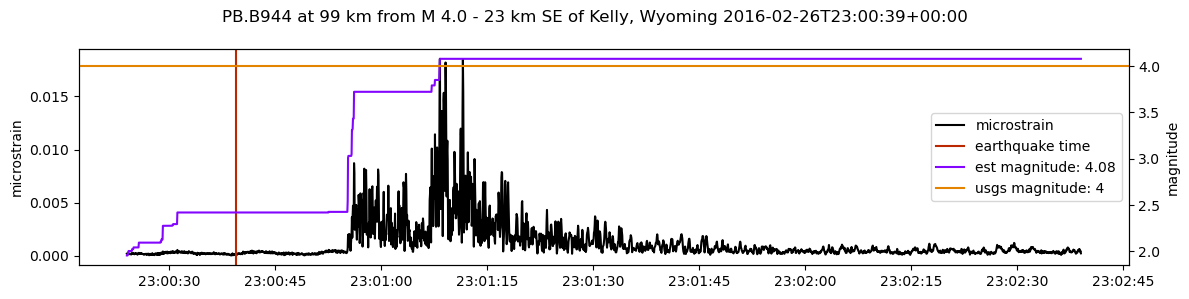

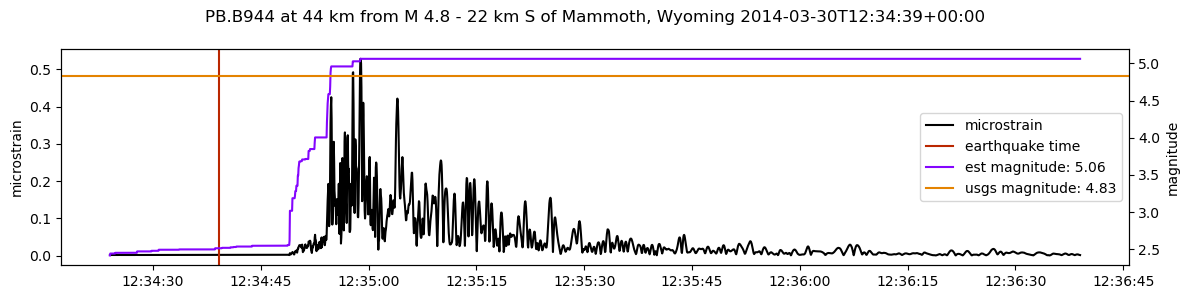

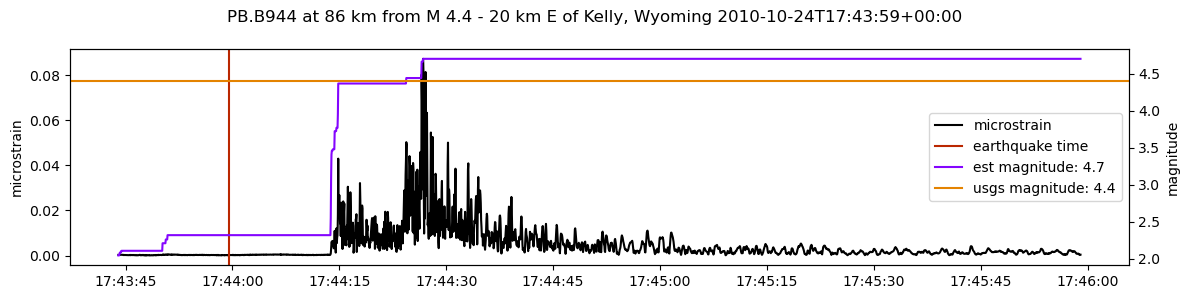

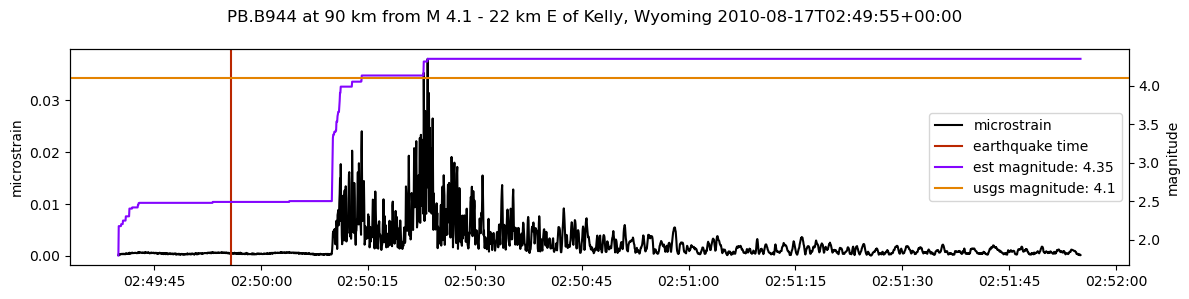

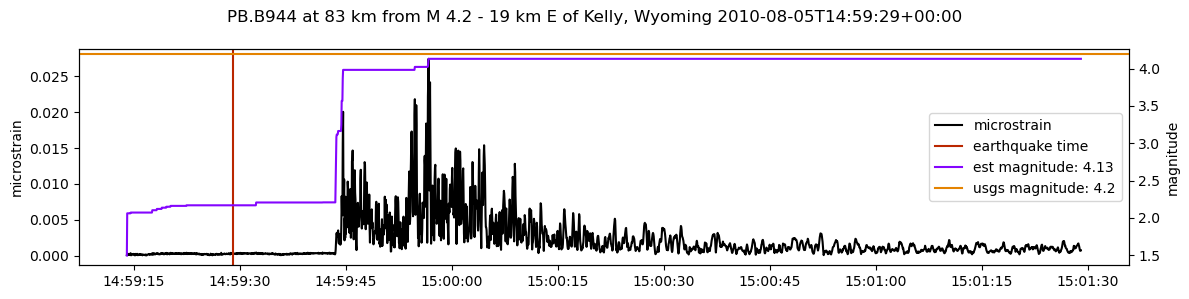

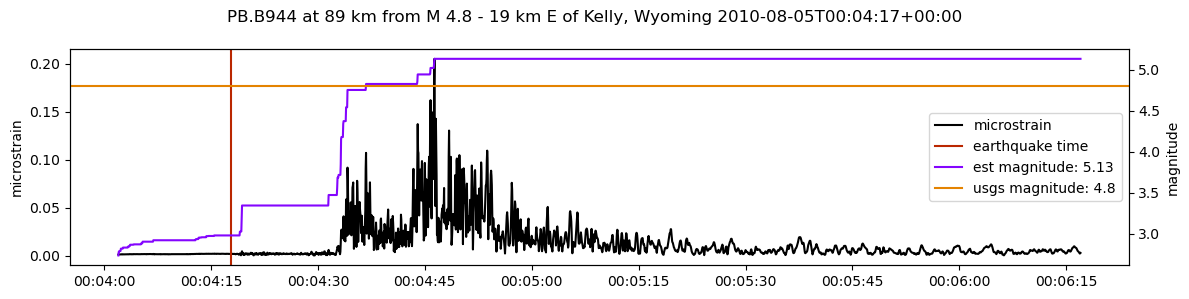

In [23]:
def get_nearby_events(latitude, longitude, radius, min_magnitude, start, end):
    url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime={start}&endtime={end}&minmagnitude={min_magnitude}&latitude={latitude}&longitude={longitude}&maxradiuskm={radius}"
    eqs = pd.read_csv(url, index_col='time', parse_dates=True)
    return eqs

radius = 100 
min_magnitude = 4
start = meta.start_date
end = datetime.now().isoformat()
eqs = get_nearby_events(meta.latitude, meta.longitude, radius, min_magnitude, start, end)
for index in eqs.index:
    print(eqs.loc[index].id, eqs.loc[index].place, index.isoformat(timespec='seconds'))
    try:
        plot_event(station, meta, eqs.loc[index].id)
    except: 
        pass
